DELAY LINE SIMULATION SETUP

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the endpoints of a mirror given center, length, and angle
def calculate_mirror_endpoints(center, length, angle):
    half_length = length / 2
    angle_rad = np.radians(angle)
    start = (
        center[0] - half_length * np.cos(angle_rad),
        center[1] - half_length * np.sin(angle_rad),
    )
    end = (
        center[0] + half_length * np.cos(angle_rad),
        center[1] + half_length * np.sin(angle_rad),
    )
    return start, end

# Function to find the intersection of two lines
def find_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    A1, B1, C1 = y2 - y1, x1 - x2, x1 * y2 - y1 * x2
    A2, B2, C2 = y4 - y3, x3 - x4, x3 * y4 - y3 * x4
    det = A1 * B2 - A2 * B1
    if det == 0:
        return None  # Lines are parallel
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    # Check if the intersection is within both line segments
    if (min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2) and
        min(x3, x4) <= x <= max(x3, x4) and min(y3, y4) <= y <= max(y3, y4)):
        return (x, y)
    return None

# Function to calculate the reflection of a laser beam
def reflect_laser(laser_start, laser_angle, mirrors, last_mirror):
    laser_angle_rad = np.radians(laser_angle)
    laser_far_end = (
        laser_start[0] + np.cos(laser_angle_rad) * 1000,
        laser_start[1] + np.sin(laser_angle_rad) * 1000,
    )
    
    closest_intersection = None
    closest_mirror = None
    min_distance = float('inf')

    # Find the closest intersection, ignoring the last mirror hit
    for mirror in mirrors:
        if mirror == last_mirror:
            continue
        intersection = find_intersection(laser_start, laser_far_end, mirror[0], mirror[1])
        if intersection is not None:
            distance = np.linalg.norm(np.array(intersection) - np.array(laser_start))
            if distance < min_distance:
                min_distance = distance
                closest_intersection = intersection
                closest_mirror = mirror

    if closest_intersection is None:
        return None, None, None  # No reflection
    
    # Reflection calculation
    mirror_start, mirror_end = closest_mirror
    mirror_vector = np.array([mirror_end[0] - mirror_start[0], mirror_end[1] - mirror_start[1]])
    mirror_length = np.linalg.norm(mirror_vector)
    mirror_unit_vector = mirror_vector / mirror_length
    normal_vector = np.array([-mirror_unit_vector[1], mirror_unit_vector[0]])
    incident_vector = np.array([closest_intersection[0] - laser_start[0], closest_intersection[1] - laser_start[1]])
    reflection_vector = (
        incident_vector - 2 * np.dot(incident_vector, normal_vector) * normal_vector
    )
    reflected_end = (
        closest_intersection[0] + reflection_vector[0],
        closest_intersection[1] + reflection_vector[1],
    )
    return closest_intersection, reflected_end, closest_mirror

In [3]:
# Function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

# Simulate laser reflections with length calculation
def simulate_laser_with_length(laser_start, laser_angle, mirrors, max_reflections=36):
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None
    laser_path = [laser_start]  # Track laser path

    for _ in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections; add final endpoint and break
            laser_far_end = (
                current_position[0] + np.cos(np.radians(current_angle)) * 1000,
                current_position[1] + np.sin(np.radians(current_angle)) * 1000,
            )
            laser_path.append(laser_far_end)
            break

        # Update the path and continue simulation
        laser_path.append(intersection)
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    # Calculate total laser length
    total_length = sum(calculate_distance(laser_path[i], laser_path[i + 1]) for i in range(len(laser_path) - 2))
    return laser_path, total_length

def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.73*dx, p1[1] - 0.73*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.73*dx, p2[1] + 0.73*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=44):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

def select_furthest_orthogonal_line(endpoint, ortho_p1, ortho_p2, reference_x=200):
    """Select the orthogonal line endpoint furthest away from reference_x."""
    # Calculate distances from reference_x for each orthogonal endpoint
    dist_ortho_p1 = abs(ortho_p1[0] - reference_x)
    dist_ortho_p2 = abs(ortho_p2[0] - reference_x)
    
    # Return the endpoint further from reference_x
    if dist_ortho_p1 > dist_ortho_p2:
        return (endpoint, ortho_p1)
    else:
        return (endpoint, ortho_p2)

def process_mirrors(mirrors):
    doubled_lines = []
    orthogonal_lines = []
    
    for p1, p2 in mirrors:
        # Double the length of the original line
        extended_p1, extended_p2 = extend_line(p1, p2)
        doubled_lines.append((extended_p1, extended_p2))

        # Create orthogonal lines at the endpoints of the doubled line
        ortho_p1_a, ortho_p1_b = create_orthogonal_line_at_endpoint(extended_p1, extended_p2)
        ortho_p2_a, ortho_p2_b = create_orthogonal_line_at_endpoint(extended_p2, extended_p1)
        
        # Select only the orthogonal line furthest from x=100
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p1, ortho_p1_a, ortho_p1_b))
        orthogonal_lines.append(select_furthest_orthogonal_line(extended_p2, ortho_p2_a, ortho_p2_b))

    return doubled_lines, orthogonal_lines

In [5]:
def extend_line(p1, p2):
    # Calculate the length of the line
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    # Extend the line in both directions
    new_p1 = (p1[0] - 0.79*dx, p1[1] - 0.79*dy)  # Extend p1 backwards
    new_p2 = (p2[0] + 0.79*dx, p2[1] + 0.79*dy)  # Extend p2 forwards
    return new_p1, new_p2

def create_orthogonal_line_at_endpoint(endpoint, other_endpoint, length=65):
    """Create an orthogonal line of the specified length at a given endpoint."""
    # Calculate the direction vector of the original line
    dx = other_endpoint[0] - endpoint[0]
    dy = other_endpoint[1] - endpoint[1]
    
    # Get orthogonal direction
    orthogonal_dx = -dy
    orthogonal_dy = dx
    magnitude = np.sqrt(orthogonal_dx**2 + orthogonal_dy**2)
    unit_dx = orthogonal_dx / magnitude
    unit_dy = orthogonal_dy / magnitude

    # Compute the two endpoints of the orthogonal line
    ortho_p1 = (endpoint[0] + unit_dx * length, endpoint[1] + unit_dy * length)
    ortho_p2 = (endpoint[0] - unit_dx * length, endpoint[1] - unit_dy * length)
    return ortho_p1, ortho_p2

In [7]:
mirror_lengths = [19.4, 19.4, 19.4, 19.4]

# Set up the laser
laser_start = (0, 100)
laser_angle = 0  # Initial laser angle in degrees

In [9]:
def execution(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    # Initialize plot
    plt.figure(figsize=(12, 10))
    plt.scatter(*laser_start, color='red', label="Laser Source", linewidth=1)

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Draw the mirrors
    for i, mirror in enumerate(mirrors):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], 
                 label=f"Mirror {i+1}", linewidth=3)

    #Draw piezo mirror mounts outline for fitting purposes
    for i, mirror in enumerate(doubled_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1)

    for i, mirror in enumerate(orthogonal_lines):
        plt.plot([mirror[0][0], mirror[1][0]], [mirror[0][1], mirror[1][1]], linewidth=1)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    for i in range(max_reflections):
        intersection, reflected_end, hit_mirror = reflect_laser(current_position, current_angle, mirrors, last_mirror)
        if intersection is None:
            # No more intersections
            plt.plot(
                [current_position[0], current_position[0] + np.cos(np.radians(current_angle)) * 1000],
                [current_position[1], current_position[1] + np.sin(np.radians(current_angle)) * 1000],
                'g--', label=f"Laser Beam {i+1}"
            )
            break

        # Draw the laser and reflection
        plt.plot([current_position[0], intersection[0]], [current_position[1], intersection[1]], 'r-', linewidth =1)
        #plt.plot([intersection[0], reflected_end[0]], [intersection[1], reflected_end[1]], 'g-')
        plt.scatter(*intersection, color='orange', label=f"Intersection {i+1}")
    
        # Update for next reflection
        current_position = intersection
        current_angle = np.degrees(np.arctan2(
            reflected_end[1] - intersection[1],
            reflected_end[0] - intersection[0],
        ))
        last_mirror = hit_mirror

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    print("Laser Path:", laser_path)
    print("Total Laser Length:", total_length+distance, "mm")

    # Finalize plot
    plt.xlim(-310, 360)
    plt.ylim(-10, 210)
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    #plt.axhline(100, color='black', linewidth=1)
    #plt.axvline(200, color='black', linewidth=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(prop={'size': 5})
    plt.title("Laser Reflection with Multiple Mirrors")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.grid(True, linewidth=0.3)
    plt.plot([-100,-100],[142, 146], linewidth=4)
    plt.plot([-300, -300], [195, 199], linewidth=4)
    plt.show()

Laser Path: [(0, 100), (211.9058688331848, 100.0), (121.32840812018605, 54.246032276211004), (269.727081734641, 52.173861246192324), (78.75311927768621, 107.65692627645205), (210.52006561126987, 105.81699305969202), (120.31019200166199, 58.656410828405306), (270.07072326508904, 54.473220416394696), (78.68334954133289, 107.19008606980574), (211.0739375272011, 103.49208210553913), (121.18046120375455, 54.88686077540883), (269.2053361965644, 48.682780334277254), (-698.5038342854009, 300.7521385774135)]
Total Laser Length: 1903.5521181748277 mm


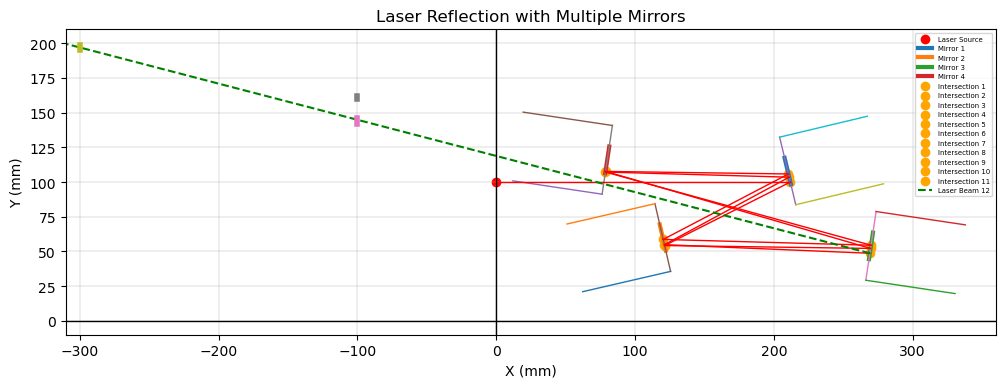

In [11]:
execution(210, 108, #M1, (x,y)
          120, 60, #M2, (x,y)
          270, 54, #M3, (x,y)
          80, 116, #M4, (x,y)
          103.4, 103, 81.5, 81.5) # Angle from positive x-axis (M1, M2, M3, M4)

In [13]:
def execution_identifier(m1cx, m1cy, m2cx, m2cy, m3cx, m3cy, m4cx, m4cy, m1a, m2a, m3a, m4a):
    mirrors = []

    # MIRROR CONFIGURATION
    mirror_centers = [(m1cx, m1cy), (m2cx, m2cy), (m3cx, m3cy), (m4cx, m4cy)]
    mirror_angles = [m1a, m2a, m3a, m4a] #in degrees

    for center, length, angle in zip(mirror_centers, mirror_lengths, mirror_angles):
        mirrors.append(calculate_mirror_endpoints(center, length, angle))

    #Piezo mount outline visualizer
    doubled_lines, orthogonal_lines = process_mirrors(mirrors)

    # Simulate laser reflections
    max_reflections = 36
    current_position = laser_start
    current_angle = laser_angle
    last_mirror = None

    laser_path, total_length = simulate_laser_with_length(laser_start, laser_angle, mirrors)

    #Indicate where to cut off laser distance calculation (x=?)
    a=laser_path[-2]
    b=laser_path[-1]
    x=0
    slope = (b[1] - a[1]) / (b[0] - a[0])
    y = a[1] + slope * (x - a[0])
    x_point = (x, y)
    distance = np.sqrt((x_point[0] - a[0])**2 + (x_point[1] - a[1])**2)

    #print("Laser Path:", laser_path[-2:])

    last_two = laser_path[-2:]
    exit_slope = (last_two[1][1]-last_two[0][1])/(last_two[1][0]-last_two[0][0])
    #print("slope:", exit_slope)
    y_int=last_two[1][1]-exit_slope*last_two[1][0]
    y100=exit_slope*-100+y_int
    y300 = exit_slope*-300+y_int
    #print("y-value at x=-100 (Should be between 144 and 146):", y100)
    #print(y_int)
    #print("Total Laser Length:", total_length+distance, "mm")
    return exit_slope, total_length + distance, y100 - 144, y300 - 197


In [19]:
execution_identifier(210, 108,
          120, 60,
          270, 54,
          80, 116,
          103.4, 103, 81.5, 81.1)

# prints: (slope of exiting beam, total length of beam, distance away from center of qc1, distance away from center of qc2)

(-0.2604804893164182,
 1321.830868810371,
 1.3532754339803432,
 0.4493732972639748)

Finding Mirror Parameters for a Given Distance. Current code is limited for (1904 to 2486 distance). Can be improved/built upon in the future. Following shows that there are several possible arrangements for given desired lengths.

In [22]:
min_p=[210,108,
         120,60,
         270,54,
         80,116]

In [24]:
max_p=[260,108,
         70,60,
         270,54,
         80,116]

In [26]:
from scipy.optimize import fsolve
def eq_x_f(x_f, L_f, x_1, y_1, x_2, y_2, y_i):
    return np.sqrt((x_1 - x_f)**2 + (y_1 - y_i)**2) + np.sqrt((x_2 - x_f)**2 + (y_2 - y_i)**2) - L_f

In [27]:
def eq_L_i(x_1, y_1, x_2, y_2, x_i, y_i):
    return np.sqrt((x_1 - x_i)**2 + (y_1 - y_i)**2) + np.sqrt((x_2 - x_i)**2 + (y_2 - y_i)**2)

In [30]:
results = []
def mirror_parameters(distance):
    min_p=[210,108,
         120,60,
         270,54,
         80,116]
    
    lower_bound = -0.265
    upper_bound = -0.255
    if 1904 <= distance < 2486:
        
        a1_range = np.arange(96, 104, 0.1)
        a2_range = np.arange(96, 104, 0.1)
        a3_range = np.arange(79, 82,0.5)
        a4_range = np.arange(79, 82,0.5)
        
        if distance <= 2195:
            L_i = eq_L_i(min_p[0], min_p[1], min_p[4], min_p[5], min_p[2], min_p[3])
            L_f = (distance-1904)/3 + L_i
            x_f_initial = 100
            x_f_solution = fsolve(eq_x_f, x_f_initial, args=(L_f, min_p[0], min_p[1], min_p[4], min_p[5], min_p[3]))[0]  
            min_p[2]=round(x_f_solution,2)
            for a1 in a1_range:
                for a2 in a2_range:
                    for a3 in a3_range:
                        for a4 in a4_range:
                            result = execution_identifier(min_p[0], min_p[1], min_p[2], min_p[3],
                                      min_p[4], min_p[5], min_p[6], min_p[7],
                                      a1, a2, a3, a4)

                            slope, laser_length, qc_height = result[0], result[1], result[2]

                            if lower_bound < slope < upper_bound and 1900<laser_length<2500 and 144<qc_height<146:
                                results.append((round(a1,2), round(a2,2), round(a3,2), round(a4,2)))
        print(min_p)

    return results

In [32]:
#%%time #Note: this may take a few minutes
#mirror_parameters(1950)

Sensitivity Matrix for Idealistic Simulation Setup

In [36]:
order_id = [0, 2, 8, 9]

def sensitivity_matrix(x0, y0, delta):
    y0 = y0
    n_inputs = len(x0)
    n_outputs = len(y0)

    M = np.zeros((n_outputs, n_inputs))

    for j in range(n_inputs):
        x0_perturb = x0.copy()

        x0_perturb[j] += delta
        values[order_id[j]] = x0_perturb[j]
        qc = execution_identifier(*values)
        y_perturb = qc[-2:]

        values[order_id[j]] = x0[j]

        M[:, j] = (np.array(y_perturb) - np.array(y0)) / delta

    return M

Laser Path: [(0, 100), (241.33874087265139, 100.0), (101.34349405613708, 51.795770791771965), (269.49512938694824, 50.62183184793541), (78.64137292371916, 107.51780774364973), (240.83885135903162, 102.98722194164309), (101.53499492869248, 50.62634466380119), (268.6237768412445, 44.79147582597631), (-697.3020494478219, 303.61052092850423)]
Total Laser Length: 1513.0809336374148 mm


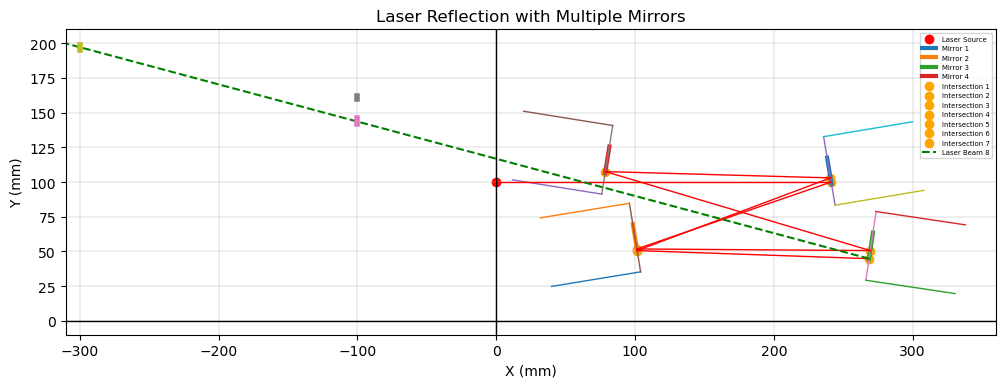

In [38]:
execution(240, 108, 
          100, 60, 
          270, 54, 
          80, 116, 
          99.5, 99.3, 81.5, 80.9)

In [40]:
execution_identifier(240, 108, 
          100, 60, 
          270, 54, 
          80, 116, 
          99.5, 99.3, 81.5, 80.9)

(-0.26794919243113063,
 1513.0809336374148,
 -0.43608085849891154,
 0.15375762772720236)

Beam is not centered on quadcells based on the output above

In [55]:
values = [240, 108, 
          100, 60, 
          270, 54, 
          80, 116, 
          99.5, 99.3, 81.5, 80.9]

qc = execution_identifier(*values)

delta = 0.005

qc = qc[-2:]

x0 = [values[0],
     values[2],
     values[8], values[9]] # initial actuator values
y0 = qc

M = sensitivity_matrix(x0, y0, delta)

delta_q = -np.array(qc)
adj = 0.0
delta_a_known = np.array([adj, 0.0])

# Split M
M1 = M[:, :2]  # columns for delta_a1, delta_a2
M2 = M[:, 2:]  # columns for delta_a3, delta_a4

# Right-hand side
rhs = delta_q - M1 @ delta_a_known

# Solve for delta_a3 and delta_a4
delta_a_unknown = np.linalg.lstsq(M2, rhs, rcond=None)[0]

print("delta_a_3 and delta_a_4:", delta_a_unknown) # The angle change necessary to be applied to M1, M2

delta_a_3 and delta_a_4: [-0.2777708  -0.31712941]


The corrected mirror parameters to center the beam in the quadcells. Note the two last small numbers in the first list; These correspond to the deviation from the center of the qcs. In this case, they are just about centered.

(-0.2650063229021812, 1513.322569690426, 0.0035666101850324594, 0.0048311906212745725)
Laser Path: [(0, 100), (241.29890266699147, 100.0), (101.07000278360212, 53.23117164924961), (269.6745578152647, 51.82241549539661), (78.7894517782014, 108.44229492246906), (240.69862501771559, 103.69713706518948), (101.17383787027072, 52.574311789428506), (268.8429291591755, 46.25785822524219), (-697.7904196581894, 302.4218075899536)]
Total Laser Length: 1513.322569690426 mm


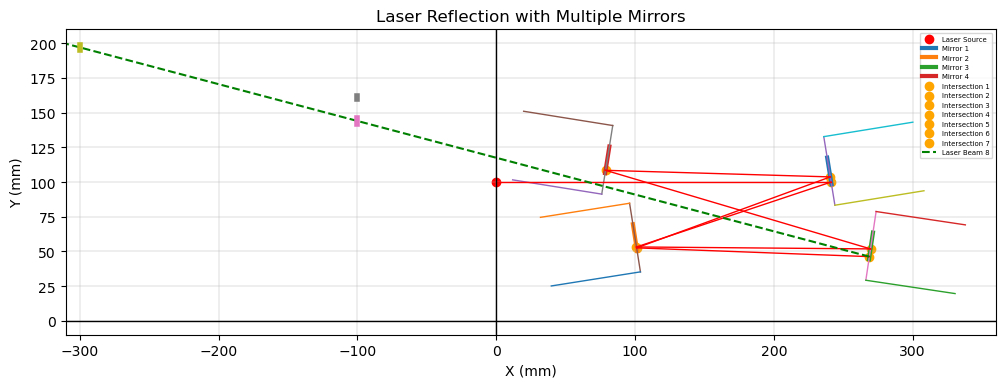

In [44]:
a1 = values[8] + delta_a_unknown[0]
a2 = values[9] + delta_a_unknown[1]
i1 = values[0] + adj

print(execution_identifier(i1, 108, 
          100, 60, 
          270, 54, 
          80, 116, 
          a1, a2, 81.5, 80.9))
execution(i1, 108, 
          100, 60, 
          270, 54, 
          80, 116, 
          a1, a2, 81.5, 80.9)